## The goal of this work was to train a Machine Learning model to enable cheap and reasonable predictions of FRED docking scores for the ENAMINE REAL data set against a confidential Relay Tx target. Current costs for this at Relay Tx were:
<img src="./Slide_Images/Notebook_Slide0.png" width="550px" />

## Therefore a reasonable ML model could save significant time and therefore money for filtering out molecules via FRED.

## These results are from using Chemprop (http://chemprop.csail.mit.edu) which is a Directed Message Passing Neural Network deep learning algorithm that passes messages over bond features of small molecules for property prediction. I had also tried as a comparison an XGBoost with different types of Fingerprints as features and got quite low performance in comparison (R^2 < 0.4 for XGBoost; R^2 = 0.613 for Chemprop). 

### Again, I haven't had time yet to clean every thing in this code and check it for exact reproducibility, therefore there are probably some things are be hard coded. Please use this as a guideline for what I've done and how one could evaluate these results for this context. Also I didn't have time to do hyperparameter optimization for Chemprop so default settings were used with training. Additionally, I am purposely obscuring smiles strings as I don't want to breach confidentiality of Relay Tx. I also apologize that I haven't gone and carefully commented each line of code. I'm not doing anything exceptionally difficult here, so hopefully things should be self-explanatory, but if you do have questions about anything, please feel free to ask me and I'll be happy to try and answer if I have time!

# Summary slides of results/explanations

<img src="./Slide_Images/Notebook_Slide1.png" width="550px" />

Attempt to train on a million molecules and test on a billion paradigm. Application for FRED Docking (low resolution) on a particular confidential Relay Tx target. A colleague had previously run FRED low res docking of the full ENAMINE REAL data set and my goal was to train an ML model on a million and test on much more. If performance was robust enough then this could be a huge time and cost saver for getting reasonable predictions of FRED scores for a lot of molecules. Thereby allowing fast and cheap filtering out of the worst scoring molecules. For this data set I did a stratified k-fold sampling based on Reaction ID of 1 million compounds and also did a stratified sampling for the 10 million test molecules (removing overlaps between train and test set, hence getting ~9 million compounds for my test set). I then trained chemprop on these 1 million compounds and tested on the 9 million. In theory, this approach could be done for many more sampled compounds but we simply ran out of time (for my internship) in order to do more rigorous comparisons. As you can see this FRED docking distribution centers around -10.


<img src="./Slide_Images/Notebook_Slide2.png" width="550px" />

What we observe is a model capable of getting an R^2 of 0.613 on 9 million test compounds when only trained on a million. With these results we are able to essentially only have to run a million compounds through FRED while still being able to predict possible actives with some decent degree of accuracy. Thereby halving the computational burden/cost. Again we observe that the model is biased to learning the mean and exploring potential sampling approaches may help with this.

So building a great regression model is good, but what do we really care about? Can we filter out ‘hits’ from not hits well with model?

<img src="./Slide_Images/Notebook_Slide3.png" width="550px" />

So the question that we wanted to answer was how well does the model recover molecules that truly have FRED scores <= -15 when using different threshold cutoffs to filter out molecules. As we can see by the left plot, When you choose a threshold of -10, you are able to recover 99% of molecules that had a FRED score that was truly <= -15 and at a threshold of -12, we see that 77% recovery is achieved. The plot on the right shows the percent of molecules that were predicted as ‘Active’ out of the entire data set when using the various cutoffs. So in other words, with a threshold of -10 chosen, 54% of the data set was predicted to be below <= -10 of which 99% of the molecules that were truly <= -15 were recovered among that predicted set. 

In a sense the computation time for recovering 99% of the -15 molecules was halved because you’d only need to run the molecules that were predicted <= -10 through FRED. This is a big win!

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle
import time
import glob
%matplotlib inline

In [2]:
main_path = os.getcwd()
plot_path = os.path.join(main_path,'Plots')
dat_path = os.path.join(main_path,'data','test_csvs')

In [14]:
main_path

'/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million'

In [4]:
glob.glob(os.path.join(dat_path,'test_checkpoints_preds*'))

['/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_7.csv',
 '/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_1.csv',
 '/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_0.csv',
 '/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_6.csv',
 '/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_3.csv',
 '/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_2.csv',
 '/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_8.csv',
 '/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_5.csv',
 '/home/vsharma/FRED_ML/ENAMINE/Cambridge/10million/data/test_csvs/test_checkpoints_preds_batch_4.csv']

In [5]:
%%time
ls_dfs = [pd.read_csv(df_path) for df_path in glob.glob(os.path.join(dat_path,'test_checkpoints_preds_batch_*'))]
test_pred = pd.concat(ls_dfs, ignore_index=True)
test_pred
test_real = pd.read_csv(os.path.join(dat_path,'../test.csv'))
#test_real.sort_values(['scores','smiles'],inplace=True)
# full_df = full_df.drop_duplicates('smiles')
# full_df.to_csv(os.path.join(dat_path,'output_scores.csv'),index=False)
assert set(test_pred['smiles']) == set(test_real['smiles'])

CPU times: user 20.8 s, sys: 1.26 s, total: 22.1 s
Wall time: 22.1 s


In [380]:
print(test_pred.columns)
test_pred.shape

Index(['smiles', 'scores'], dtype='object')


(8999940, 2)

In [381]:
print(test_real.columns)
test_real.shape

Index(['smiles', 'scores'], dtype='object')


(8999940, 2)

In [382]:
%%time
merged_test_df = test_real.merge(test_pred,on='smiles',how='left')
merged_test_df = merged_test_df.rename({'scores_x':'True_vals','scores_y':'Pred_vals'},axis=1)
merged_test_df = merged_test_df.loc[~(merged_test_df['Pred_vals'] == 'Invalid SMILES')]
merged_test_df['Pred_vals'] = merged_test_df['Pred_vals'].map(float)

thresh_val = -10
print(f"#################\nActives defined as values <= {thresh_val}\n#################")
merged_test_df['True_class'] = merged_test_df['True_vals'].apply(lambda x: 'Active' if x <= thresh_val else 'Inactive')
merged_test_df['Pred_class'] = merged_test_df['Pred_vals'].apply(lambda x: 'Active' if x <= thresh_val else 'Inactive')
print(merged_test_df.columns)
merged_test_df.shape

/home/vsharma/tmp/ENTER/envs/chemprop/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


#################
Actives defined as values <= -10
#################
Index(['smiles', 'True_vals', 'Pred_vals', 'True_class', 'Pred_class'], dtype='object')
CPU times: user 15.2 s, sys: 1.92 s, total: 17.2 s
Wall time: 17.2 s


(8999940, 5)

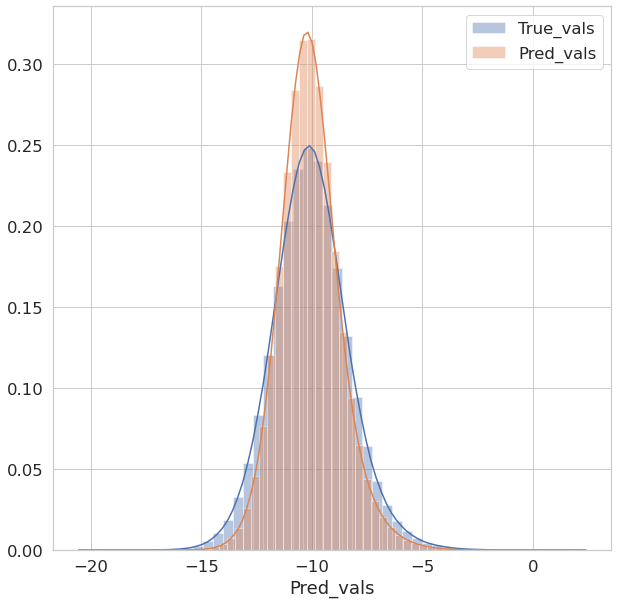

In [147]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

sns.distplot(merged_test_df['True_vals'],label='True_vals')
sns.distplot(merged_test_df['Pred_vals'],label='Pred_vals')
plt.legend()
plt.show()

CPU times: user 1h 13min 7s, sys: 6min 16s, total: 1h 19min 24s
Wall time: 8min 26s


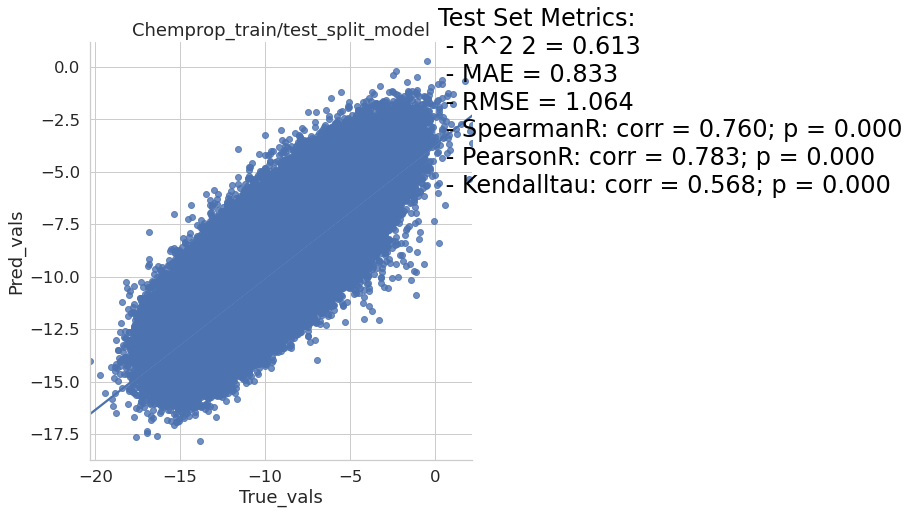

In [11]:
%%time
import scipy
import sklearn
# import time
# start_time = time.time()
y_true = merged_test_df.True_vals
y_pred = merged_test_df.Pred_vals
mae = sklearn.metrics.mean_absolute_error(y_true,y_pred)
rmse = sklearn.metrics.mean_squared_error(y_true,y_pred,squared=False)
spearr = scipy.stats.spearmanr(y_true,y_pred)
pearsonr = scipy.stats.pearsonr(y_true,y_pred)
kendalltau = scipy.stats.kendalltau(y_true,y_pred)
r2 = r2_score(y_true,y_pred)

sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.lmplot("True_vals","Pred_vals",data=merged_test_df,height=7,aspect=1)
plt.title(
    f'Chemprop_train/test_split_model'
)
plt.text(0.2, -6,
         f'Test Set Metrics:\n'
         f' - R^2 2 = {r2:.3f}\n'
         f' - MAE = {mae:.3f}\n'
         f' - RMSE = {rmse:.3f}\n'
         f' - SpearmanR: corr = {spearr[0]:.3f}; p = {spearr[1]:.3f}\n'
         f' - PearsonR: corr = {pearsonr[0]:.3f}; p = {pearsonr[1]:.3f}\n'
         f' - Kendalltau: corr = {kendalltau[0]:.3f}; p = {kendalltau[1]:.3f}',
        fontdict={'size': 24, 'color':  'black'}
       )
end_time = time.time()
# print(f'Time taken: {(end_time-start_time)/60:0.2f} min')

In [16]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.stats import gaussian_kde
# from sklearn.neighbors import KernelDensity

# Generate fake data
x = merged_test_df.True_vals
y = merged_test_df.Pred_vals

# Calculate the point density
xy = np.vstack([x,y])
# kde = KernelDensity(kernel='epanechnikov', bandwidth=0.2).fit(xy)
# kde.score_samples(X)
# z = gaussian_kde(xy,kernel='linear')(xy)

# fig, ax = plt.subplots()
# ax.scatter(x, y, c=z, s=100, edgecolor='')
#plt.show()

CPU times: user 35min 48s, sys: 6min, total: 41min 48s
Wall time: 41min 44s


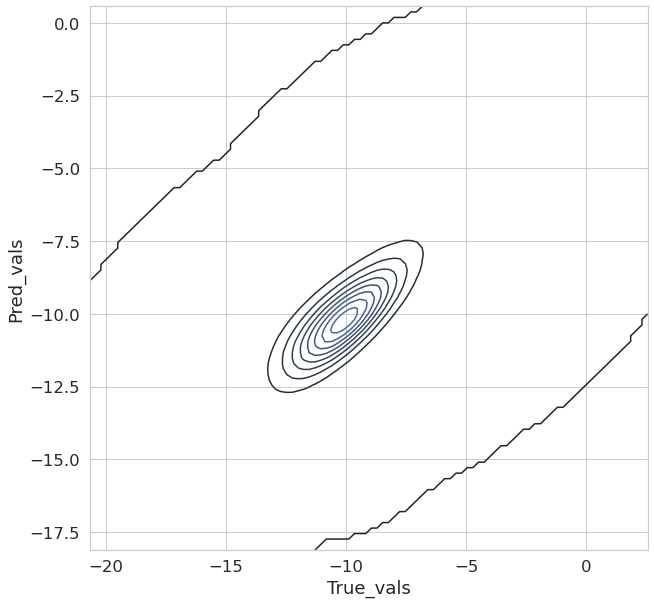

In [19]:
%%time
sns.kdeplot(x,y,kernel='epa')

# Below code is to try and evaluate how many smiles need to be actually docked in FRED in order to recover most of the smiles that get predicted values by Chemprop model <= -15. I.e. how much computation cost does this Chemprop model provide by not needing to run all ENAMINE REAL data set through FRED.

In [387]:
thresh_val = -10
if_random = False

print(f"#################\nActives defined as values <= {thresh_val}\n#################")
merged_test_df['True_class'] = merged_test_df['True_vals'].apply(lambda x: 'Active' if x <= thresh_val else 'Inactive')
merged_test_df['Pred_class'] = merged_test_df['Pred_vals'].apply(lambda x: 'Active' if x <= thresh_val else 'Inactive')
if if_random:
    merged_test_df_cp = merged_test_df.copy(deep=True)
    merged_test_df['Pred_class'] = merged_test_df['Pred_class'].sample(frac=1).reset_index(drop=True)
else:
    merged_test_df = merged_test_df_cp.copy(deep=True)


print(merged_test_df.columns)
merged_test_df.drop('smiles',axis=1)

#################
Actives defined as values <= -10
#################
Index(['smiles', 'True_vals', 'Pred_vals', 'True_class', 'Pred_class'], dtype='object')


,True_vals,Pred_vals,True_class,Pred_class
0,-10.465861,-9.954711,Active,Inactive
1,-10.279923,-10.110019,Active,Active
2,-9.825429,-8.620572,Inactive,Inactive
3,-12.114189,-12.011608,Active,Active
4,-11.310375,-10.500088,Active,Active
...,...,...,...,...
8999935,-9.490866,-9.451635,Inactive,Inactive
8999936,-9.167759,-12.188312,Inactive,Active
8999937,-9.113595,-10.473982,Inactive,Active
8999938,-10.771664,-10.475947,Active,Active


In [388]:
merged_test_df_deepcopy = merged_test_df.copy(deep=True)

In [391]:
consol_dict = {}
consol_dict_sum = {}
for thresh_val,if_random in ((-10,True),(-10,False),(-12,False),(-15,False)):
#     thresh_val = -10
#     if_random = False

    print(f"#################\nActives defined as values <= {thresh_val}; if_random = {if_random}\n#################")
    merged_test_df['True_class'] = merged_test_df['True_vals'].apply(lambda x: 'Active' if x <= thresh_val else 'Inactive')
    merged_test_df['Pred_class'] = merged_test_df['Pred_vals'].apply(lambda x: 'Active' if x <= thresh_val else 'Inactive')
    if if_random:
        merged_test_df_cp = merged_test_df.copy(deep=True)
        merged_test_df['Pred_class'] = merged_test_df['Pred_class'].sample(frac=1).reset_index(drop=True)
#     else:
        
#         merged_test_df = merged_test_df_cp.copy(deep=True)


    cp_df = merged_test_df.copy(deep=True)

    cp_df = cp_df.loc[cp_df['True_vals'] <= -15]
    cp_df['True_class'] = cp_df['True_class'].map({'Active':1,'Inactive':0})
    cp_df['Pred_class'] = cp_df['Pred_class'].map({'Active':1,'Inactive':0})
    cnts_df = cp_df.groupby(["True_class", "Pred_class"]).size().reset_index(name="Counts")
    cnts_df_cov = cp_df.groupby(['Pred_class']).size().reset_index(name="Counts")
    #cnts_df_cov = cp_df.groupby(["Pred_class"]).size().reset_index(name="Counts")
    if if_random:
        thresh_val = 'Random'
    val = merged_test_df['Pred_class'].value_counts()['Active']/merged_test_df['Pred_class'].value_counts().sum()
    consol_dict_sum['Thresh_val_'+str(thresh_val)] = val*100
    consol_dict['Thresh_val_'+str(thresh_val)] = dict(cnts_df['Counts']/np.sum(cnts_df['Counts'])*100)
    print(consol_dict_sum['Thresh_val_'+str(thresh_val)],consol_dict['Thresh_val_'+str(thresh_val)])

#merged_test_df = merged_test_df_deepcopy.copy(deep=True)

#################
Actives defined as values <= -10; if_random = True
#################
54.44412962753085 {0: 44.76201320883625, 1: 55.23798679116374}
#################
Actives defined as values <= -10; if_random = False
#################
54.44412962753085 {0: 0.6718287406057846, 1: 99.32817125939421}
#################
Actives defined as values <= -12; if_random = False
#################
6.744589408373834 {0: 22.01662491459804, 1: 77.98337508540196}
#################
Actives defined as values <= -15; if_random = False
#################
0.014588986148796548 {0: 96.87428831701207, 1: 3.1257116829879297}


In [392]:
korn_df = merged_test_df_deepcopy.copy(deep=True)
korn_df['True_class'] = korn_df['True_class'].map({'Active':1,'Inactive':0})
korn_df['Pred_class'] = korn_df['Pred_class'].map({'Active':1,'Inactive':0})
korn_df.drop('smiles',axis=1)

,True_vals,Pred_vals,True_class,Pred_class
0,-10.465861,-9.954711,1,0
1,-10.279923,-10.110019,1,1
2,-9.825429,-8.620572,0,0
3,-12.114189,-12.011608,1,1
4,-11.310375,-10.500088,1,1
...,...,...,...,...
8999935,-9.490866,-9.451635,0,0
8999936,-9.167759,-12.188312,0,1
8999937,-9.113595,-10.473982,0,1
8999938,-10.771664,-10.475947,1,1


In [347]:
cnt_df_cov = korn_df.groupby(['Pred_class']).size().reset_index(name="Counts")

In [349]:
cnt_df_cov['Counts'].loc[1]/np.sum(cnt_df_cov['Counts'])

0.5444412962753085

In [308]:
pd.DataFrame(consol_dict_sum)

,Thresh_val_Random,Thresh_val_-10,Thresh_val_-12,Thresh_val_-15
0,8007,118,3867,17015
1,9557,17446,13697,549


In [394]:
consol_df = pd.DataFrame(consol_dict)
consol_df = consol_df.rename({0:'Inactive at -15 cut',1:'Active at -15 cut'})
consol_df

,Thresh_val_Random,Thresh_val_-10,Thresh_val_-12,Thresh_val_-15
Inactive at -15 cut,44.762013,0.671829,22.016625,96.874288
Active at -15 cut,55.237987,99.328171,77.983375,3.125712


### When using different thresholds for defining a (binarizing the continuous variable into buckets of inactive vs. active) how much percent recall of true FRED scores do we get with <= -15?

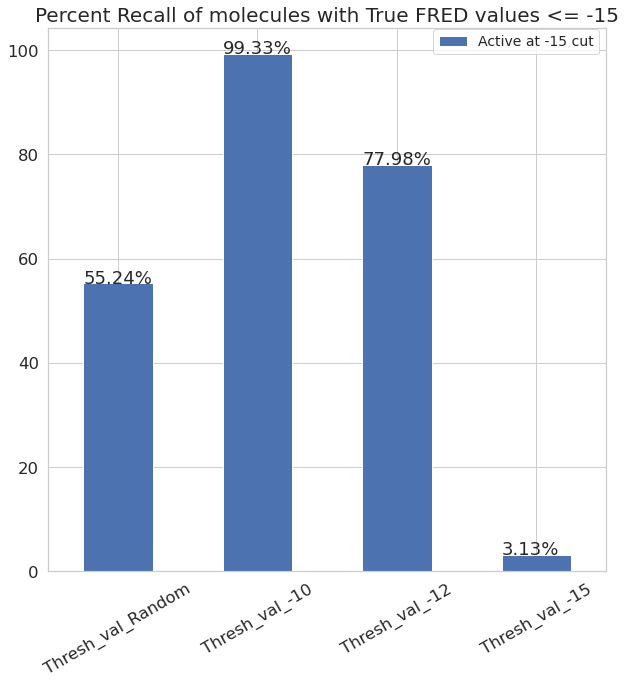

In [395]:
df_to_plot = consol_df.drop('Inactive at -15 cut').T
ax = df_to_plot.plot(kind='bar')
plt.title("Percent Recall of molecules with True FRED values <= -15",fontsize= 20)
plt.legend(loc='best',labels=df_to_plot.columns,fontsize= 14,bbox_to_anchor=(1.0, 1.01))
plt.xticks(rotation=30)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}%', (x, y + height + 0.01))

In [397]:
pd.DataFrame([consol_dict_sum],index=['Percent data coverage required'])

,Thresh_val_Random,Thresh_val_-10,Thresh_val_-12,Thresh_val_-15
Percent data coverage required,54.44413,54.44413,6.744589,0.014589


In [398]:
consol_df = pd.DataFrame([consol_dict_sum],index=['Percent data coverage required'])
#consol_df = consol_df.rename({0:'Inactive at -15 cut',1:'Active at -15 cut'})
consol_df

,Thresh_val_Random,Thresh_val_-10,Thresh_val_-12,Thresh_val_-15
Percent data coverage required,54.44413,54.44413,6.744589,0.014589


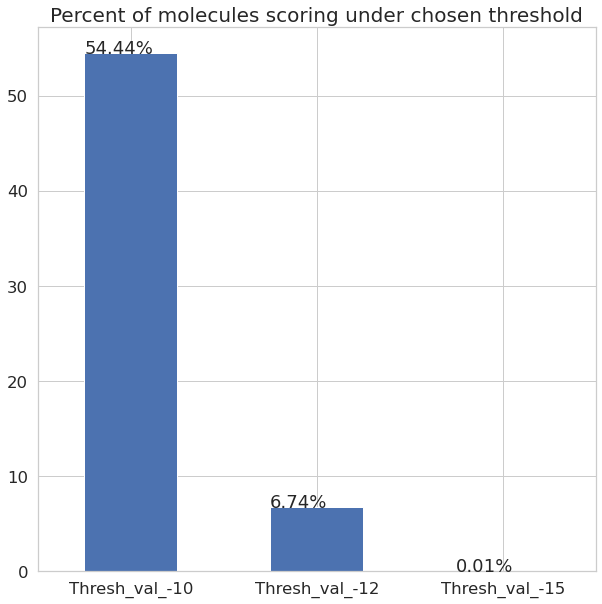

In [399]:
df_to_plot = consol_df.T.drop('Thresh_val_Random')
ax = df_to_plot.plot(kind='bar',legend=None)
plt.title("Percent of molecules scoring under chosen threshold",fontsize= 20)
#plt.legend(loc='None',labels=df_to_plot.columns,fontsize= 14,bbox_to_anchor=(1.0, 1.01))
plt.xticks(rotation=0)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}%', (x, y + height + 0.01))

In [400]:
true_act_cond = merged_test_df['True_class'] == 'Active'
pred_act_cond = merged_test_df['Pred_class'] == 'Active'

In [401]:
act_act = merged_test_df.loc[(true_act_cond & pred_act_cond)]
act_inact = merged_test_df.loc[(true_act_cond & ~pred_act_cond)]
inact_act = merged_test_df.loc[(~true_act_cond & pred_act_cond)]
inact_inact = merged_test_df.loc[(~true_act_cond & ~pred_act_cond)]
cm_raw_proper = np.array([[inact_inact.shape[0],inact_act.shape[0]],[act_inact.shape[0],act_act.shape[0]]])
print(cm_raw_proper)

[[8981612     764]
 [  17015     549]]


In [402]:
act_inact.sort_values('True_vals').drop('smiles',axis=1)

,True_vals,Pred_vals,True_class,Pred_class
4792509,-20.335815,-14.024901,Active,Inactive
3921719,-19.713768,-14.687359,Active,Inactive
5803290,-19.083282,-14.306853,Active,Inactive
7309077,-18.869745,-14.827824,Active,Inactive
4261101,-18.836573,-14.301557,Active,Inactive
...,...,...,...,...
4593938,-15.000206,-13.189107,Active,Inactive
4977936,-15.000171,-11.985971,Active,Inactive
1830348,-15.000161,-12.037795,Active,Inactive
415481,-15.000132,-10.789107,Active,Inactive


In [403]:
act_inact.loc[act_inact['True_vals'] <= -15].drop('smiles',axis=1)

,True_vals,Pred_vals,True_class,Pred_class
556,-15.136549,-13.444334,Active,Inactive
924,-15.037658,-11.479460,Active,Inactive
1446,-15.011127,-11.104154,Active,Inactive
2308,-15.196064,-12.886963,Active,Inactive
2772,-15.695520,-13.539705,Active,Inactive
...,...,...,...,...
8998427,-15.279196,-13.463651,Active,Inactive
8998619,-15.267363,-12.247587,Active,Inactive
8998744,-15.142628,-13.263663,Active,Inactive
8999595,-15.098989,-11.288190,Active,Inactive


In [207]:
# sns.distplot(act_inact['True_vals'],label = 'True')
# sns.distplot(act_inact['Pred_vals'],label = 'Pred')
# plt.legend()

#################
Actives defined as values <= -10
#################


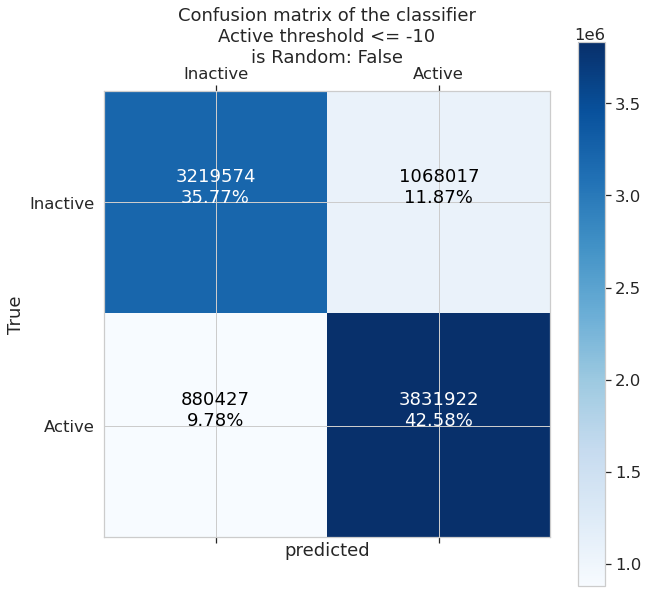

In [208]:
import itertools
from sklearn.metrics import confusion_matrix
print(f"#################\nActives defined as values <= {thresh_val}\n#################")
labels = list(set(merged_test_df['True_class']))
# cm = confusion_matrix(merged_test_df['True_class'], merged_test_df['Pred_class'])#, labels)
# cm_unnorm = cm
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = cm_raw_proper
thresh = cm.max() / 1.3 #if normalize else cm.max() / 2
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap=plt.cm.Blues)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #print("%i\n%.2f"%(cm[i, j],cm[i,j]/cm.sum()*100))
    plt.text(j, i, f"{cm[i, j]}\n{cm[i,j]/cm.sum()*100:.2f}%",
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
plt.title('Confusion matrix of the classifier\n'
          f'Active threshold <= {thresh_val}\n'
          f'is Random: {if_random}'
         )
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('predicted')
plt.ylabel('True')
#print(cm)
plt.show()



In [50]:
cm_raw_proper.shape[0]

2

#################
Actives defined as values <= -12
#################
Raw counts:
 [[ 389360  678923]
 [ 217649 7714008]]
Normalized counts:
 [[0.36447271 0.63552729]
 [0.02744055 0.97255945]]


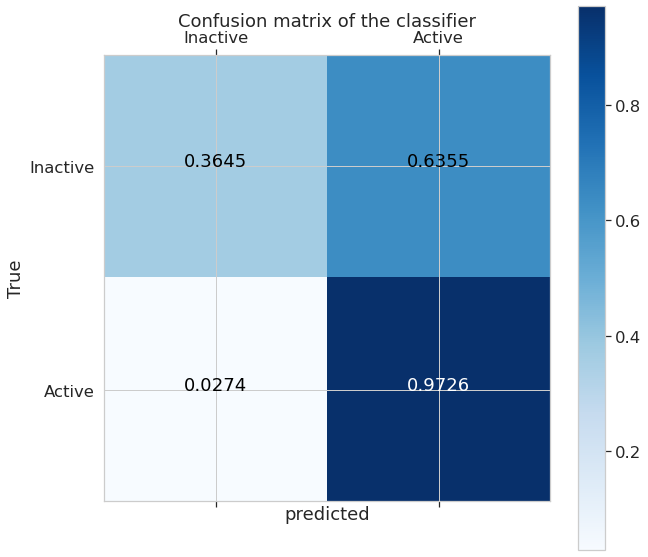

ChemProp: f1=0.465 auc=0.553


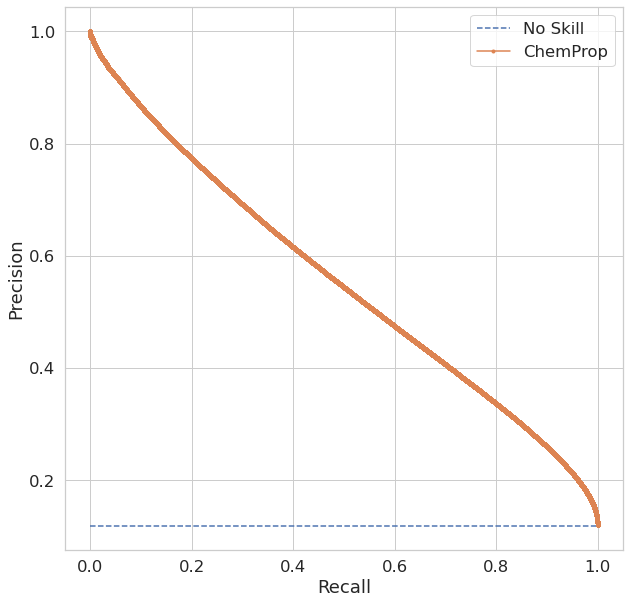

No Skill: ROC AUC=0.500
ChemProp: ROC AUC=0.878


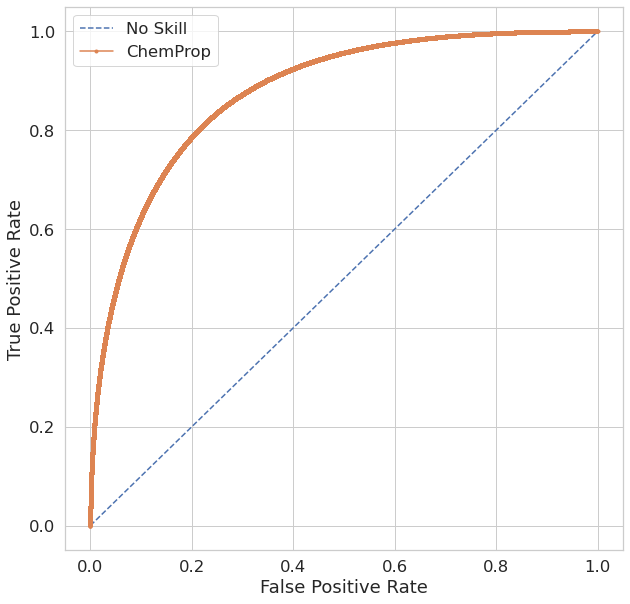

In [24]:
import itertools
from sklearn.metrics import confusion_matrix
print(f"#################\nActives defined as values <= {thresh_val}\n#################")
labels = list(set(merged_test_df['True_class']))
cm = confusion_matrix(merged_test_df['True_class'], merged_test_df['Pred_class'])#, labels)
cm_unnorm = cm
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 1.5 #if normalize else cm.max() / 2
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap=plt.cm.Blues)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
print('Raw counts:\n',cm_unnorm)
print('Normalized counts:\n',cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()

# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
#print(f"#################\nActives defined as values <= {thresh_val}\n#################")
testy = merged_test_df['True_class'].map({'Active':1,'Inactive':0})
# predict class values
pred_reg = merged_test_df['Pred_vals'].abs()
yhat = merged_test_df['Pred_class'].map({'Active':1,'Inactive':0})  #yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, pred_reg)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('ChemProp: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='ChemProp')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
#print(f"#################\nActives defined as values <= {thresh_val}\n#################")
testy = merged_test_df['True_class'].map({'Active':1,'Inactive':0})
# predict class values
pred_reg = merged_test_df['Pred_vals'].abs()
ns_probs = [0 for _ in range(len(testy))]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, pred_reg)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ChemProp: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, pred_reg)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ChemProp')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


### The following I'm commenting out because basically I was manually creating different threshold cuts which would allow for examining which threshold may be most useful. However, it takes a long time to run and I didn't have the time to send it currently.

In [404]:
# thresh_cuts = np.linspace(np.min(merged_test_df['True_vals']),np.max(merged_test_df['True_vals']),100)
# prec_f1, prec_auc, roc_auc = [],[],[]
# for thrsh in thresh_cuts:
#     thresh_val = thrsh
# #     thresh_val = -12
#     print(f"#################\nActives defined as values <= {thresh_val}\n#################")
#     merged_test_df['True_class'] = merged_test_df['True_vals'].apply(lambda x: 'Active' if x <= thresh_val else 'Inactive')
#     merged_test_df['Pred_class'] = merged_test_df['Pred_vals'].apply(lambda x: 'Active' if x <= thresh_val else 'Inactive')
#     #merged_test_df

#     import itertools
#     from sklearn.metrics import confusion_matrix
#     #print(f"#################\nActives defined as values <= {thresh_val}\n#################")
#     labels = list(set(merged_test_df['True_class']))
#     cm = confusion_matrix(merged_test_df['True_class'], merged_test_df['Pred_class'])#, labels)
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     thresh = cm.max() / 1.5 #if normalize else cm.max() / 2
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(cm,cmap=plt.cm.Blues)
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     print(cm)
#     plt.title('Confusion matrix of the classifier')
#     fig.colorbar(cax)
#     ax.set_xticklabels([''] + labels)
#     ax.set_yticklabels([''] + labels)
#     plt.xlabel('predicted')
#     plt.ylabel('True')
#     #plt.show()

#     # precision-recall curve and f1
#     from sklearn.datasets import make_classification
#     from sklearn.linear_model import LogisticRegression
#     from sklearn.model_selection import train_test_split
#     from sklearn.metrics import precision_recall_curve
#     from sklearn.metrics import f1_score
#     from sklearn.metrics import auc
#     from matplotlib import pyplot
#     #print(f"#################\nActives defined as values <= {thresh_val}\n#################")
#     testy = merged_test_df['True_class'].map({'Active':1,'Inactive':0})
#     # predict class values
#     pred_reg = merged_test_df['Pred_vals'].abs()
#     yhat = merged_test_df['Pred_class'].map({'Active':1,'Inactive':0})  #yhat = model.predict(testX)
#     lr_precision, lr_recall, _ = precision_recall_curve(testy, pred_reg)
#     lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
#     # summarize scores
#     print('ChemProp: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
#     # plot the precision-recall curves
#     no_skill = len(testy[testy==1]) / len(testy)
#     pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
#     pyplot.plot(lr_recall, lr_precision, marker='.', label='ChemProp')
#     # axis labels
#     pyplot.xlabel('Recall')
#     pyplot.ylabel('Precision')
#     # show the legend
#     pyplot.legend()
#     # show the plot
#     #pyplot.show()
    
#     prec_f1.append(lr_f1)
#     prec_auc.append(lr_auc)

#     # roc curve and auc
#     from sklearn.metrics import roc_curve
#     from sklearn.metrics import roc_auc_score
#     from matplotlib import pyplot
#     #print(f"#################\nActives defined as values <= {thresh_val}\n#################")
#     testy = merged_test_df['True_class'].map({'Active':1,'Inactive':0})
#     # predict class values
#     pred_reg = merged_test_df['Pred_vals'].abs()
#     ns_probs = [0 for _ in range(len(testy))]
#     # calculate scores
#     ns_auc = roc_auc_score(testy, ns_probs)
#     lr_auc = roc_auc_score(testy, pred_reg)
#     # summarize scores
#     print('No Skill: ROC AUC=%.3f' % (ns_auc))
#     print('ChemProp: ROC AUC=%.3f' % (lr_auc))
#     # calculate roc curves
#     ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
#     lr_fpr, lr_tpr, _ = roc_curve(testy, pred_reg)
#     # plot the roc curve for the model
#     pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
#     pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ChemProp')
#     # axis labels
#     pyplot.xlabel('False Positive Rate')
#     pyplot.ylabel('True Positive Rate')
#     # show the legend
#     pyplot.legend()
#     # show the plot
#     #pyplot.show()
    
#     roc_auc.append(lr_auc)

In [405]:
# rez_df = pd.DataFrame([thresh_cuts,prec_f1, prec_auc,roc_auc]).T
# rez_df.columns = ['Threshold_cuts','Prec_f1','Prec_AUC','ROC_AUC']
# rez_df

In [406]:
# ax = rez_df.plot(kind="line", x="Threshold_cuts",y="Prec_f1", color="b", label="Prec-Recall_f1 vs. Threshold_cuts")
# rez_df.plot(x="Threshold_cuts",y='Prec_AUC', color="r", label="Prec-Recall_AUC vs. Threshold_cuts", ax=ax)
# rez_df.plot( x="Threshold_cuts",y='ROC_AUC', color="g", label="ROC_AUC vs. Threshold_cuts", ax=ax)

# ax.set_xlabel("Threshold_cuts")
# ax.set_ylabel("Score")
# plt.show()